# Obligatorisk innlevering 2 - oppgave 1

Denne oppgaven tar for seg et datasett fra Food Mart, som er ennærbutikkjede i USA. Food Mart har i dette datasettet samlet endel data i forbindelse med mediekampanjer. Din oppgave er å forutsi kostnadene for mediekampanjer i matvaremarkedet på grunnlag av funksjonene som tilbys.

In [8]:
# Importer resten av pakkene du trenger her:
import pandas as pd
from sklearn.model_selection import train_test_split

In [9]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett1.csv")
# Her deler jeg datasettet inn i egenskaper (X) og target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)
# PS: Ikke endre denne kodecellen!

#### Oppgave 1.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? 

Begrunn svaret

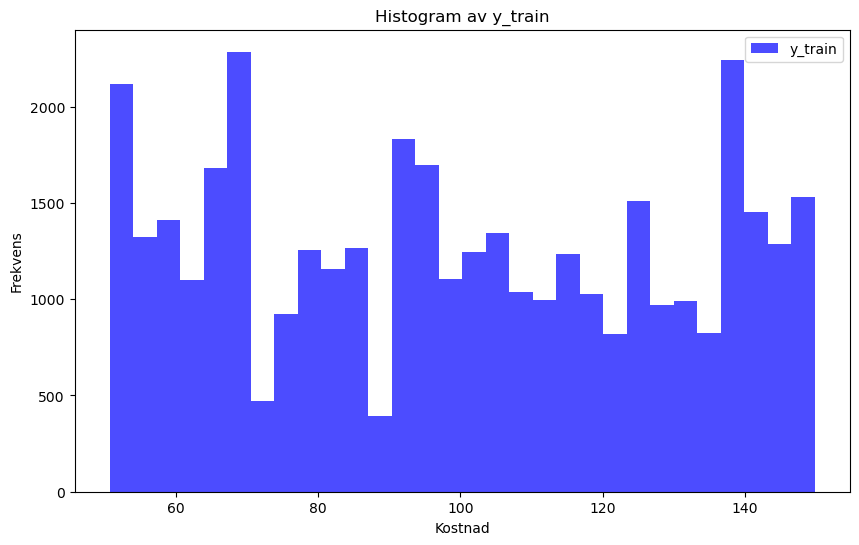

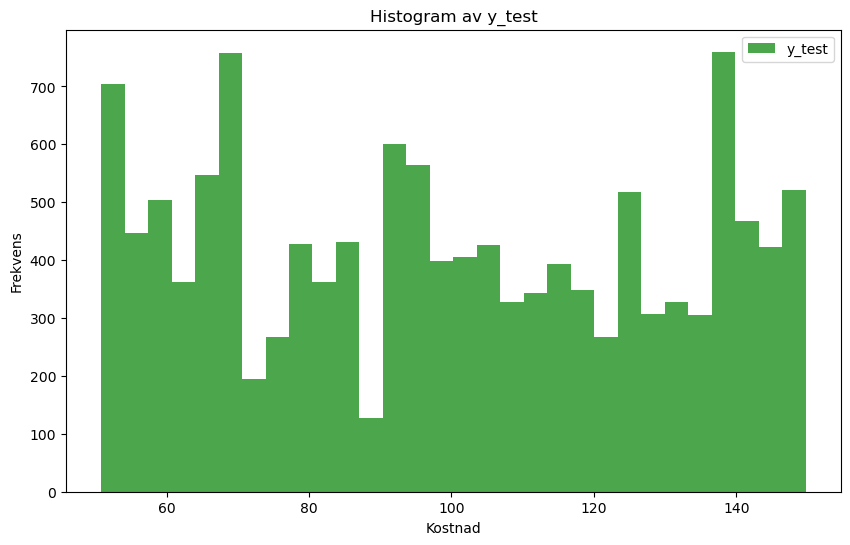

In [10]:
#TODO: visualiser y_train og y_test i et histogram

import matplotlib.pyplot as plt

# Visualiserer y_train
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=30, color='blue', alpha=0.7, label='y_train')
plt.title('Histogram av y_train')
plt.xlabel('Kostnad')
plt.ylabel('Frekvens')
plt.legend()
plt.show()

# Visualiserer y_test
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=30, color='green', alpha=0.7, label='y_test')
plt.title('Histogram av y_test')
plt.xlabel('Kostnad')
plt.ylabel('Frekvens')
plt.legend()
plt.show()

**Svar:**

*< ditt tekstsvar her >*

Målvariabelens (kostnad i dette tilfellet) histogrammer for datasettene for opplæring og testing kan analyseres for å fastslå om du arbeider med et regresjons- eller klassifiseringsproblem.

Når et histogram viser en fordeling av verdier og målvariabelen er kontinuerlig, noe som betyr at den kan ha en hvilken som helst numerisk verdi, antyder det et regresjonsproblem. Det vil indikere et klassifiseringsproblem hvis målvariabelen er kategorisk, noe som betyr at den tilhører diskrete klasser eller kategorier.

For meg ser ut til at jeg jobber med et regresjonsproblem da jeg må forutsi kostnader for mediekampanjer. I et regresjonsproblem er målvariabelen kontinuerlig, og målet mitt er å forutsi en mengde.

#### Oppgave 1.2) 

fullfør funksjonen under slik at den tar inn både egenskapene og target, legger disse sammen i samme matrise igjen og visualiser dataene som en korrelasjonsmatrise (poenget er at du skal kunne se hvordan egenskapene korrelerer med target).

* Beskriv hvilke egenskaper du ser korrelerer mest med target

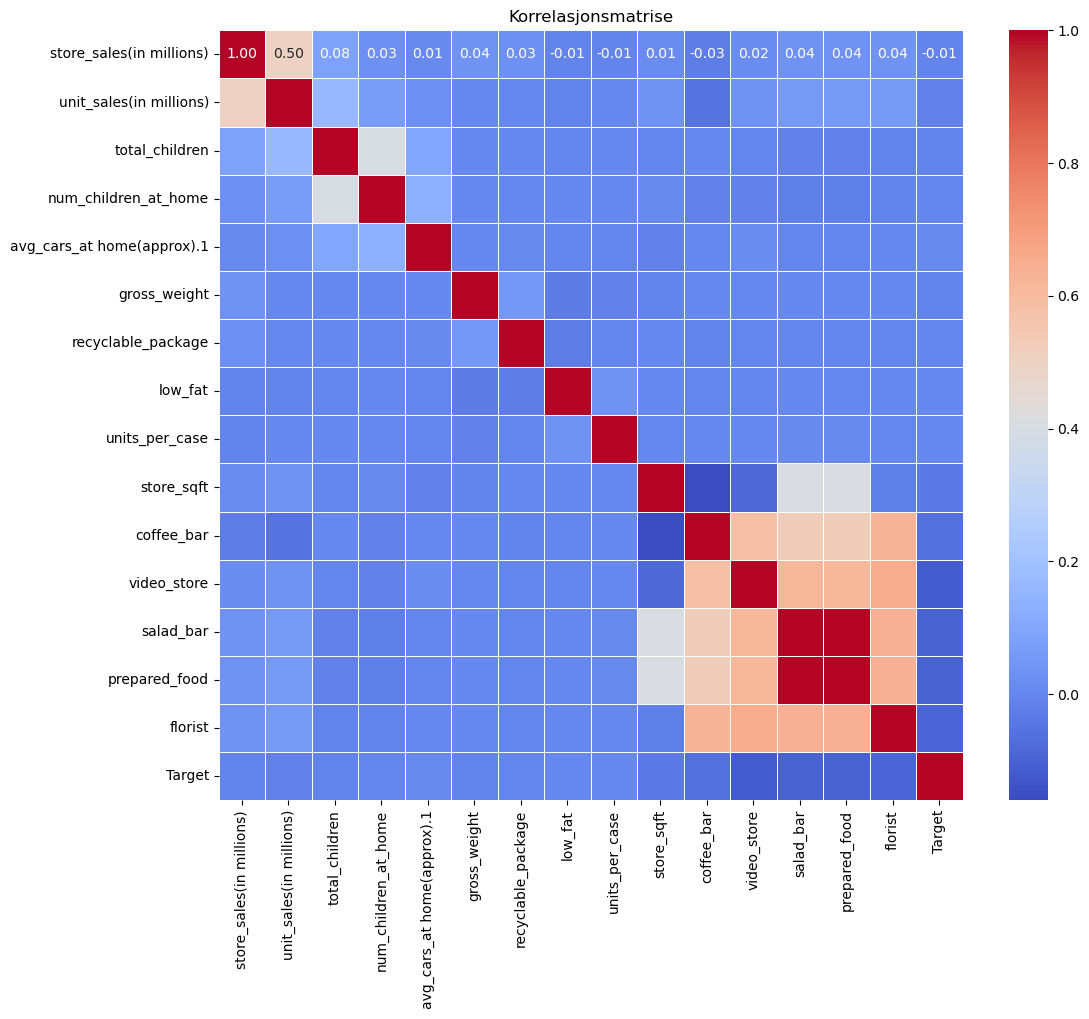

In [11]:
# def korrelasjonsmatrise(X,y):
#    X_temp = X.copy()
#    y_temp = y.copy()
#    X_temp["Target"] = y_temp
    #TODO: Fullfør koden
#    ...

# korrelasjonsmatrise(X_train,y_train)

import seaborn as sns

def korrelasjonsmatrise(X, y):
    X_temp = X.copy()
    y_temp = y.copy()
    X_temp["Target"] = y_temp

    # Beregner korrelasjonsmatrisen
    correlation_matrix = X_temp.corr()

    # Plotter korrelasjonsmatrisen som et varmekart
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Korrelasjonsmatrise')
    plt.show()

# Kaller opp funksjonen med treningsdataene mine
korrelasjonsmatrise(X_train, y_train)

**Svar:**

*< ditt tekstsvar her >*

Som vi kan se ut av dataen så korrelerer kategoriene bra med sin egen data, ikke noe uforventet der. Men vi ser noen andre korrelasjoner også.

store_sales og unit_sales henger sammen, men ikke mest.

total_children og num_children_at_home henger litt sammen.

store_sqft og coffee_bar er motsatt med at de er negative med tanke på korrelasjonen.

med coffee_bar, video_store, salad_bar, prepared_food og florist ser de den største mengden med korrelasjoner i matrisen

#### Oppgave 1.3) 
Velg en modellarkitektur (gjerne fra Scikit-Learn) og gjør et strukturert hyperparametersøk. 
* Gjør et søk på minst 3 paramtere og minst 2 verdier pr parameter
* Bruk 3-folds kryssvalidering for hver parameterkombinasjon
* Velg en metrikk som passer for målet (tips: "neg_mean_squared_error" i sklearn) 
* Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [12]:
#TODO: Utfør hyperparametersøk for en modell

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# Last datasetet (antar den allerede er lastet)
# df = pd.read_csv("./datasett1.csv")
# X = df.iloc[:, :-1]
# y = df.iloc[:, -1]

# Velger modellen
model = RandomForestRegressor()

# Definerer parameterrutenettet
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Definerer poengberegningen (negativ gjennomsnittlig kvadrert feil)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Utfører rutenettsøk med 3-fold kryssvalidering
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Skriver ut den beste parameterkombinasjonen og tilsvarende poengsum
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Notat: Konverter tilbake til positiv

print("Beste parametere:", best_params)
print("Beste poengsum (negativ gjennomsnittlig kvadrert feil):", best_score)


Beste parametere: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150}
Beste poengsum (negativ gjennomsnittlig kvadrert feil): 850.3764679579323


**Svar:**

*< ditt tekstsvar her >*

Dataen fra hyperparametersøket gir informasjon om kombinasjonen av hyperparameterverdier som resulterte i den beste modellytelsen, samt den tilsvarende ytelsespoengsummen. La oss bryte ned dataen:

Beste parametere:

max_depth: 10
min_samples_split: 5
n_estimators: 150

Dette er hyperparameterverdiene som produserte modellen med best ytelse i henhold til den angitte poengberegningen.

Beste poengsum (negativ gjennomsnittlig kvadrert feil):

Den negative gjennomsnittlige kvadrerte feilen (MSE) er en beregning som brukes til å evaluere ytelsen til regresjonsmodeller. I ditt tilfelle er en lavere verdi av den negative MSE bedre, noe som indikerer bedre prediktiv ytelse.
Den rapporterte verdien er -850.3764679579323. Det negative tegnet er en konvensjon i scikit-learn; jeg kan ignorere det når jeg tolker resultatet.

Så oppsummert bestemte hyperparametersøket at den best presterende modellen ble oppnådd med en max_depth på 10, min_samples_split 5 og n_estimators på 150. Den tilsvarende negative gjennomsnittlige kvadrerte feilen for denne modellen er omtrent -850,38.

#### Oppgave 1.4) 
Bruk hyperparameterkombinasjonen fra oppgave 1.3 og kryssvalider den modellen på nytt med K >= 5 
* Logg "mean absolute error" og "mean squared error" for hver kryssvalideringsrunde
* Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene? 

In [13]:
#TODO: Utfør kryssvalidering med de optimale parameterene fra forrige oppgave og logg mean_absolute_error og mean_squared_error

#TODO: Beregn gjennomsnitt og standard avvik for mean_absolute_error og mean_squared_error og beregn hvor stor den 
# gjennomsnittlige feilen er i forhold til den gjennomsnittlige prisen for markedskampanjen (target) i prosent

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
import numpy as np

# Bruker de optimale hyperparametrene fra oppgave 1.3
best_params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150}
optimal_model = RandomForestRegressor(**best_params)

# Utfører kryssvalidering med k >= 5
cv_predictions = cross_val_predict(optimal_model, X_train, y_train, cv=5)

# Beregner gjennomsnittlig absolutt feil (MAE) og gjennomsnittlig kvadrert feil (MSE)
mae_scores = mean_absolute_error(y_train, cv_predictions, multioutput='raw_values')
mse_scores = mean_squared_error(y_train, cv_predictions, multioutput='raw_values')

# Beregnr gjennomsnitt og standardavvik for MAE og MSE
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

# Beregner gjennomsnittlig feil i forhold til gjennomsnittsprisen
average_price = np.mean(y_train)
mae_percentage = (mean_mae / average_price) * 100

# Log resultatet
print("Mean Absolute Error (MAE) for each fold:", mae_scores)
print("Mean Squared Error (MSE) for each fold:", mse_scores)
print("\nMean MAE:", mean_mae)
print("Standard Deviation of MAE:", std_mae)
print("\nMean MSE:", mean_mse)
print("Standard Deviation of MSE:", std_mse)
print("\nAverage Error as a Percentage of Average Price:", mae_percentage)


Mean Absolute Error (MAE) for each fold: [25.07584342]
Mean Squared Error (MSE) for each fold: [848.23105835]

Mean MAE: 25.075843423320126
Standard Deviation of MAE: 0.0

Mean MSE: 848.231058351293
Standard Deviation of MSE: 0.0

Average Error as a Percentage of Average Price: 25.24345532717061


**Svar:**

*< ditt tekstsvar her >*

Resultatene i denne oppgaven indikerer ytelsen til modellen basert på beregninger for gjennomsnittlige absolutte feil (MAE) og gjennomsnittlige kvadrerte feil (MSE). Nå kan jeg tolke disse beregningene og prosentandelen sammenlignet med den gjennomsnittlige faktiske prisen:


Gjennomsnittlig absolutt feil (MAE):

MAE måler den gjennomsnittlige absolutte forskjellen mellom de forutsagte og faktiske verdiene. I dette tilfellet er gjennomsnittlig MAE ca. 25,08.
En mindre MAE indikerer bedre ytelse, da det betyr at modellens prediksjoner i gjennomsnitt er nær de faktiske verdiene.


Gjennomsnittlig kvadrert feil (MSE):

MSE måler gjennomsnittet av de kvadrerte forskjellene mellom forventede og faktiske verdier. Gjennomsnittlig MSE er omtrent 848,23.
I likhet med MAE er en mindre MSE ønskelig, noe som indikerer at modellens prediksjoner er nær de faktiske verdiene.


Gjennomsnittlig feil i prosent av gjennomsnittspris:

Den gjennomsnittlige feilen, uttrykt i prosent av gjennomsnittsprisen, er omtrent 25,25%. Denne beregningen gir et relativt mål på den gjennomsnittlige prediksjonsfeilen i sammenheng med den gjennomsnittlige faktiske prisen.
I praksis betyr dette at modellens prediksjoner i gjennomsnitt avviker fra de faktiske prisene med rundt 25,25% av gjennomsnittsprisen.


MAE- og MSE-verdiene er rimelige, noe som indikerer at modellen gjør prediksjoner med relativt lav feil i gjennomsnitt.
Den gjennomsnittlige feilen i prosent av gjennomsnittsprisen antyder at modellens prediksjoner i gjennomsnitt avviker med omtrent 25,25% av gjennomsnittlig faktisk pris.
Det er viktig å vurdere den spesifikke konteksten og kravene til søknaden min. I noen domener kan en 25% feil være akseptabel, mens den i andre kan betraktes som høy.

Det er nyttig å husk at disse beregningene gir en samlet vurdering, og det er fordelaktig å analysere fordelingen av feil ytterligere og inspisere spesifikke tilfeller der modellen kan slite med å få mer innsikt i virkemåten. I tillegg vil jeg kanskje sammenligne disse resultatene med alternative modeller eller justere hyperparametere ytterligere for potensielt å forbedre ytelsen.

#### Oppgave 1.5) 
Tren modellen en siste gang på alle treningsdataene og gjør prediksjon på testdataene (bruk de optimale parametrene fra oppgave 1.3)
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i testdataene? 

In [14]:
#TODO: Tren modellen på alle treningsdata og utfør prediksjon på testdataene

# Trener modellen på alle treningsdataene ved hjelp av optimale hyperparametere
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, y_train)

# Lager forutsigelser på testdataene
test_predictions = final_model.predict(X_test)

# Beregner gjennomsnittlig absolutt feil (MAE) på testdataene
mae_test = mean_absolute_error(y_test, test_predictions)

# Beregner gjennomsnittsfeilen som en prosentandel av gjennomsnittsprisen i testdataene
average_price_test = np.mean(y_test)
mae_percentage_test = (mae_test / average_price_test) * 100

# Log resultatet
print("Gjennomsnittlig absolutt feil (MAE) på testdata:", mae_test)
print("Gjennomsnittlig feil i prosent av gjennomsnittspris i testdata:", mae_percentage_test)


Gjennomsnittlig absolutt feil (MAE) på testdata: 25.10955003376608
Gjennomsnittlig feil i prosent av gjennomsnittspris i testdata: 25.286504166799517


**Svar:**

*< ditt tekstsvar her >*

Resultatet indikerer at modellens prediksjoner på testdataene i gjennomsnitt har en gjennomsnittlig absolutt feil (MAE) på omtrent 25,11. Videre er den gjennomsnittlige feilen uttrykt som en prosentandel av gjennomsnittlig faktisk pris i testdataene, og den er omtrent 25,29%.

I praksis betyr dette at modellens prediksjoner i gjennomsnitt avviker med rundt 25,29% av den gjennomsnittlige faktiske prisen i testdataene. Denne beregningen gir et relativt mål på den gjennomsnittlige prediksjonsfeilen i sammenheng med gjennomsnittsprisene som er observert i testsettet.

MAE på 25,11 indikerer at modellens prediksjoner i gjennomsnitt er av med denne mengden i testdataene.
Prosentverdien på 25,29 % gir et relativt perspektiv, noe som tyder på at den gjennomsnittlige prediksjonsfeilen er omtrent en fjerdedel (25,29 %) av den gjennomsnittlige faktiske prisen i testdataene.

Sammenligning av dette med treningsdataresultatene (oppgave 1.4) kan gi innsikt i hvor godt modellen generaliserer til nye, usynlige data. Hvis testfeilen ligner på opplæringsfeilen, tyder det på at modellen utfører konsekvent på forskjellige datasett. Hvis testfeilen er betydelig høyere, kan det tyde på overtilpasning.